In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import cmocean
import xarray as xr
import xroms
import glob
import os
import datetime
import numpy as np
import dateutil
import dask
from functools import partial
from scipy.signal import butter, filtfilt

import collections.abc
collections.Iterable = collections.abc.Iterable
import xscale

In [2]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster(dashboard_address=':8787')
w = cluster.scale(5*14)
client = Client(cluster)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41543 instead
  warnings.warn(
2025-06-25 12:27:25,464 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0e4baed31dd39e1b1bd16e65a2607080 initialized by task ('rechunk-merge-rechunk-transfer-a0e462642bb8dae9da320ea50fc2629d', 0, 0, 0, 0, 0, 0) executed on worker tcp://127.0.0.1:43535
2025-06-25 12:27:26,449 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0e4baed31dd39e1b1bd16e65a2607080 deactivated due to stimulus 'task-finished-1750843646.4434097'
2025-06-25 12:37:08,588 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0e4baed31dd39e1b1bd16e65a2607080 initialized by task ('rechunk-merge-rechunk-transfer-a0e462642bb8dae9da320ea50fc2629d', 0, 0, 0, 0, 0, 0) executed on worker tcp://127.0.0.1:43131
2025-06-25 12:37:09,467 - distributed.shuffle._schedul

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41543/status,
Dashboard: http://127.0.0.1:41543/status,Workers: 70
Total threads: 560,Total memory: 1.07 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33317,Workers: 70
Dashboard: http://127.0.0.1:41543/status,Total threads: 560
Started: Just now,Total memory: 1.07 TiB
Comm: tcp://127.0.0.1:34015,Total threads: 8
Dashboard: http://127.0.0.1:35753/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:32869,


In [4]:
data_path = '/southern/rbarkan/data/SWC2km/OUTPUT/W_rivers/HIS/'
save_path = '/meddy/lwang/data/SWC2km_Wrivers_data/'
sub_savepath = save_path + 'KE_exchanges/Pi_omega/'
figure_dir = '/meddy/lwang/figures/KE_exchanges/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

if not os.path.exists(sub_savepath):
    os.makedirs(sub_savepath)

In [107]:
filenames = sorted(glob.glob(data_path+'z_SWC2km_his.145367.nc')) 
print('Number of files processed: %d' %len(filenames))
ds = xr.open_mfdataset(filenames, concat_dim='time', combine="nested")
ds

Number of files processed: 1


<xarray.Dataset> Size: 2GB
Dimensions:     (time: 6, depth: 5, eta_rho: 1296, xi_u: 1501, eta_v: 1295,
                 xi_rho: 1502)
Coordinates:
  * depth       (depth) float32 20B -2.0 -100.0 -500.0 -1e+03 -4e+03
Dimensions without coordinates: time, eta_rho, xi_u, eta_v, xi_rho
Data variables:
    ocean_time  (time) float64 48B dask.array<chunksize=(6,), meta=np.ndarray>
    time_step   (time) int32 24B dask.array<chunksize=(6,), meta=np.ndarray>
    u           (time, depth, eta_rho, xi_u) float32 233MB dask.array<chunksize=(6, 5, 1296, 1501), meta=np.ndarray>
    v           (time, depth, eta_v, xi_rho) float32 233MB dask.array<chunksize=(6, 5, 1295, 1502), meta=np.ndarray>
    temp        (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    salt        (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    w           (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    Akv         (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    Akt         (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>

In [108]:
ds.u

<xarray.DataArray 'u' (time: 6, depth: 5, eta_rho: 1296, xi_u: 1501)> Size: 233MB
dask.array<open_dataset-u, shape=(6, 5, 1296, 1501), dtype=float32, chunksize=(6, 5, 1296, 1501), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 20B -2.0 -100.0 -500.0 -1e+03 -4e+03
Dimensions without coordinates: time, eta_rho, xi_u
Attributes:
    long_name:  u-momentum component
    units:      meter second-1

In [82]:
grid = xr.open_dataset('/southern/rbarkan/data/SWC2km/SWC2km_grd.nc')
#ds_u = xr.open_zarr(save_path + 'surface_u_rechunk.zarr')
#ds_v = xr.open_zarr(save_path + 'surface_v_rechunk.zarr')
#ds = xr.merge([ds_u,ds_v,grid])
ds['pm']= (['eta_rho', 'xi_rho'],grid['pm'].data)
ds['pn']= (['eta_rho', 'xi_rho'],grid['pn'].data)
ds['f']= (['eta_rho', 'xi_rho'],grid['f'].data)

ds, xgrid = xroms.roms_dataset(ds, include_cell_volume=True)
ds.xroms.set_grid(xgrid)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. T

In [75]:
def oceantime_to_date(oceantime):
    t0 = datetime.datetime(2000,1,1)    
    ltime = np.array(oceantime)
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

    
dtime = oceantime_to_date(ds['ocean_time'])

In [83]:
ds_u = ds['u'].isel(depth=0)
ds_v = ds['v'].isel(depth=0)

In [84]:
ds_u

<xarray.DataArray 'u' (time: 6, eta_rho: 1296, xi_u: 1501)> Size: 47MB
dask.array<getitem, shape=(6, 1296, 1501), dtype=float32, chunksize=(6, 1296, 1501), chunktype=numpy.ndarray>
Coordinates:
    depth    float32 4B -2.0
  * xi_u     (xi_u) int64 12kB 0 1 2 3 4 5 6 ... 1495 1496 1497 1498 1499 1500
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  u-momentum component
    units:      meter second-1

In [85]:
ds_v

<xarray.DataArray 'v' (time: 6, eta_v: 1295, xi_rho: 1502)> Size: 47MB
dask.array<getitem, shape=(6, 1295, 1502), dtype=float32, chunksize=(6, 1295, 1502), chunktype=numpy.ndarray>
Coordinates:
    depth    float32 4B -2.0
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_v    (eta_v) int64 10kB 0 1 2 3 4 5 6 ... 1289 1290 1291 1292 1293 1294
Dimensions without coordinates: time
Attributes:
    long_name:  v-momentum component
    units:      meter second-1

In [102]:
dudxi = xroms.hgrad(
    ds_u,
    xgrid,
    which="xi",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)
dvdeta = xroms.hgrad(
    ds_v,
    xgrid,
    which="eta",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)

dvdxi = xroms.hgrad(
    ds_v,
    xgrid,
    which="xi",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)
dudeta = xroms.hgrad(
    ds_u,
    xgrid,
    which="eta",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dime

In [93]:
ds_u

<xarray.DataArray 'u' (time: 6, eta_rho: 1296, xi_u: 1501)> Size: 47MB
dask.array<getitem, shape=(6, 1296, 1501), dtype=float32, chunksize=(6, 1296, 1501), chunktype=numpy.ndarray>
Coordinates:
    depth    float32 4B -2.0
  * xi_u     (xi_u) int64 12kB 0 1 2 3 4 5 6 ... 1495 1496 1497 1498 1499 1500
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  u-momentum component
    units:      meter second-1

In [112]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 6, depth: 5, eta_rho: 1296, xi_u: 1501, eta_v: 1295,
                 xi_rho: 1502)
Coordinates:
  * depth       (depth) float32 20B -2.0 -100.0 -500.0 -1e+03 -4e+03
Dimensions without coordinates: time, eta_rho, xi_u, eta_v, xi_rho
Data variables:
    ocean_time  (time) float64 48B dask.array<chunksize=(6,), meta=np.ndarray>
    time_step   (time) int32 24B dask.array<chunksize=(6,), meta=np.ndarray>
    u           (time, depth, eta_rho, xi_u) float32 233MB dask.array<chunksize=(6, 5, 1296, 1501), meta=np.ndarray>
    v           (time, depth, eta_v, xi_rho) float32 233MB dask.array<chunksize=(6, 5, 1295, 1502), meta=np.ndarray>
    temp        (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    salt        (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    w           (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    Akv         (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    Akt         (time, depth, eta_rho, xi_rho) float32 234MB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>

In [111]:
ds.u.roms.hdiff("xi")

AttributeError: 'DataArray' object has no attribute 'roms'

In [95]:
du_dx = xgrid.diff(ds_u, 'X')/(1/grid.pm)
du_dx

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


<xarray.DataArray (time: 6, eta_rho: 1296, xi_rho: 1502)> Size: 93MB
dask.array<truediv, shape=(6, 1296, 1502), dtype=float64, chunksize=(6, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  u-momentum component
    units:      meter second-1

In [97]:
dv_dy = xgrid.diff(ds_v, 'Y')/(1/grid.pn)
dv_dy

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


<xarray.DataArray (time: 6, eta_rho: 1296, xi_rho: 1502)> Size: 93MB
dask.array<truediv, shape=(6, 1296, 1502), dtype=float64, chunksize=(6, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  v-momentum component
    units:      meter second-1

In [100]:
gridx.interp(xgrid.diff(ds_u, 'Y'),'X','Y')

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


<xarray.DataArray 'u' (time: 6, eta_v: 1295, xi_u: 1501)> Size: 47MB
dask.array<transpose, shape=(6, 1295, 1501), dtype=float32, chunksize=(6, 1295, 1501), chunktype=numpy.ndarray>
Coordinates:
  * xi_u     (xi_u) int64 12kB 0 1 2 3 4 5 6 ... 1495 1496 1497 1498 1499 1500
  * eta_v    (eta_v) int64 10kB 0 1 2 3 4 5 6 ... 1289 1290 1291 1292 1293 1294
Dimensions without coordinates: time
Attributes:
    long_name:  u-momentum component
    units:      meter second-1

In [101]:
1/grid.pn

<xarray.DataArray 'pn' (eta_rho: 1296, xi_rho: 1502)> Size: 16MB
array([[2517.7923659 , 2517.79236589, 2517.79236588, ..., 2517.79237233,
        2517.79237234, 2517.79237236],
       [2516.83994732, 2516.83994731, 2516.8399473 , ..., 2516.83995374,
        2516.83995376, 2516.83995378],
       [2515.88749643, 2515.88749642, 2515.88749641, ..., 2515.88750284,
        2515.88750286, 2515.88750288],
       ...,
       [1405.27398939, 1405.27398939, 1405.27398938, ..., 1405.27399162,
        1405.27399163, 1405.27399164],
       [1404.57064649, 1404.57064649, 1404.57064649, ..., 1404.57064872,
        1404.57064873, 1404.57064874],
       [1403.86758739, 1403.86758739, 1403.86758739, ..., 1403.86758962,
        1403.86758963, 1403.86758964]])
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  curvilinear coordinate metric in ETA-direction
    units:      meter-1

In [ ]:
du_dx = xgrid.diff(ds_u, 'X')/(1/grid.pm)
dv_dy = xgrid.diff(ds_v, 'Y')/(1/grid.pn)
du_dy = xgrid.diff(ds_u, 'Y')/(1/grid.pn)
dv_dx = xgrid.diff(ds_v, 'X')/(1/grid.pm)

/tmp/ipykernel_949319/2160192776.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = m.pcolormesh(xp, yp, depth, vmin=0, vmax=8000, cmap=cmocean.cm.deep)


Text(0, 0.5, 'Depth [m]')

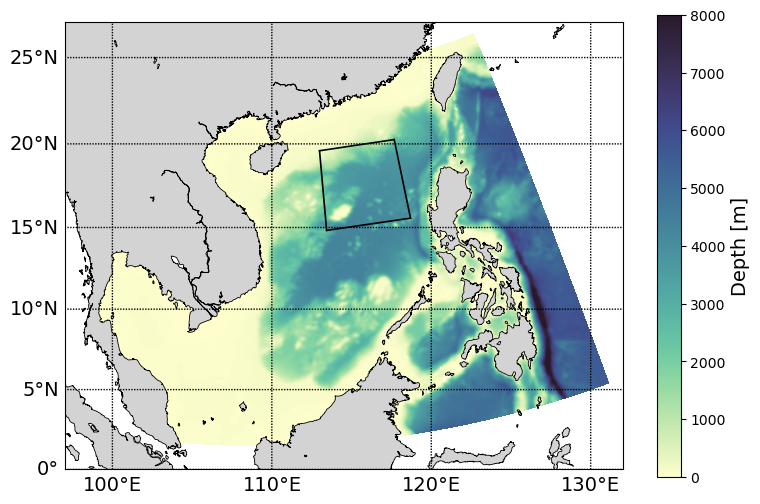

In [10]:
i0, i1 = 750, 1050
j0, j1 = 665, 965

mask=grid.mask_rho
depth = grid.h.where(mask > 0)
lat, lon = np.array(grid['lat_rho']), np.array(grid['lon_rho'])

fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grid['lon_rho'], grid['lat_rho'])
plot = m.pcolormesh(xp, yp, depth, vmin=0, vmax=8000, cmap=cmocean.cm.deep)

xp_upperleft, yp_upperleft = m(lon[j0,i1],lat[j0,i1])
xp_upperright, yp_upperright = m(lon[j1,i1],lat[j1,i1])
xp_lowerleft, yp_lowerleft = m(lon[j0,i0],lat[j0,i0])
xp_lowerright, yp_lowerright = m(lon[j1,i0],lat[j1,i0])
plt.plot([xp_upperleft,xp_upperright],[yp_upperleft,yp_upperright],'k-',linewidth=1.2)
plt.plot([xp_upperleft,xp_lowerleft],[yp_upperleft,yp_lowerleft],'k-',linewidth=1.2)
plt.plot([xp_lowerleft,xp_lowerright],[yp_lowerleft,yp_lowerright],'k-',linewidth=1.2)
plt.plot([xp_upperright,xp_lowerright],[yp_upperright,yp_lowerright],'k-',linewidth=1.2)

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=14)

In [16]:
grid = xr.open_dataset('/meddy/lwang/data/SWC2km_Wrivers_data/KE_exchanges/SWC2km_subgrd.nc')
ds_u = xr.open_zarr(save_path + 'surface_u_rechunk.zarr')
ds_v = xr.open_zarr(save_path + 'surface_v_rechunk.zarr')

i0, i1 = 900, 1050
j0, j1 = 770, 920
ds_u = ds_u.sel(time=slice("2017-01-01", "2017-3-01"), xi_rho=slice(i0,i1), eta_rho=slice(j0,j1))
ds_v = ds_v.sel(time=slice("2017-01-01", "2017-3-01"), xi_rho=slice(i0,i1),eta_rho=slice(j0,j1))
#ds_u = ds_u.sel(xi_rho=slice(i0,i1), eta_rho=slice(j0,j1))
#ds_v = ds_v.sel(xi_rho=slice(i0,i1),eta_rho=slice(j0,j1))

ds = xr.merge([ds_u,ds_v,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset> Size: 265MB
Dimensions:     (eta_rho: 151, time: 1440, xi_rho: 151, eta_v: 150, xi_u: 150)
Coordinates:
  * eta_rho     (eta_rho) int64 1kB 770 771 772 773 774 ... 916 917 918 919 920
  * time        (time) datetime64[ns] 12kB 2017-01-01T00:21:32 ... 2017-03-01...
  * xi_rho      (xi_rho) int64 1kB 900 901 902 903 904 ... 1047 1048 1049 1050
Dimensions without coordinates: eta_v, xi_u
Data variables: (12/23)
    u           (time, eta_rho, xi_rho) float32 131MB dask.array<chunksize=(1, 151, 151), meta=np.ndarray>
    v           (time, eta_rho, xi_rho) float32 131MB dask.array<chunksize=(1, 151, 151), meta=np.ndarray>
    angle       (eta_rho, xi_rho) float64 182kB ...
    cent_lat    float64 8B ...
    f           (eta_rho, xi_rho) float64 182kB ...
    flip_xy     float64 8B ...
    ...          ...
    spherical   |S1 1B ...
    tapering    float64 8B ...
    tra_lat     float64 8B ...
    tra_lon     float64 8B ...
    wgt         (eta_rho, xi_rho) float64 182kB ..

In [17]:
ds, xgrid = xroms.roms_dataset(ds, include_cell_volume=True)
ds.xroms.set_grid(xgrid)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. T

In [18]:
xgrid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xi_rho --> inner
  * inner    xi_u --> center
Y Axis (not periodic, boundary=None):
  * center   eta_rho --> inner
  * inner    eta_v --> center

### xscale spatial filter

In [33]:
grid_num = 30 # grid_num*2 km filter
time_length = 1440
eta_length, xi_length = 151, 151

wt_U = ds['u'].window
wt_U.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_U_filter = wt_U.convolve()

wt_V = ds['v'].window
wt_V.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_V_filter = wt_V.convolve()

wt_U2 = (ds['u']**2).window
wt_U2.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_U2_filter = wt_U2.convolve()

wt_V2 = (ds['v']**2).window
wt_V2.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_V2_filter = wt_V2.convolve()

wt_UV = (ds['u']*ds['v']).window
wt_UV.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_UV_filter = wt_UV.convolve()

In [26]:
u = ds['u'][100,:,:].load()

grid_num = 5 # grid_num*2 km filter
time_length = 1440
eta_length, xi_length = 151, 151

wt_U = ds['u'].window
wt_U.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_U_filter = wt_U.convolve()

u_filter_10km = ds_U_filter[100,:,:].load()


grid_num = 15 # grid_num*2 km filter
time_length = 1440
eta_length, xi_length = 151, 151

wt_U = ds['u'].window
wt_U.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_U_filter = wt_U.convolve()

u_filter_30km = ds_U_filter[100,:,:].load()


grid_num = 30 # grid_num*2 km filter
time_length = 1440
eta_length, xi_length = 151, 151

wt_U = ds['u'].window
wt_U.set(n={'eta_rho': grid_num, 'xi_rho': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_U_filter = wt_U.convolve()

u_filter_60km = ds_U_filter[100,:,:].load()

Text(0.5, 1.0, 'u_filter_60km')

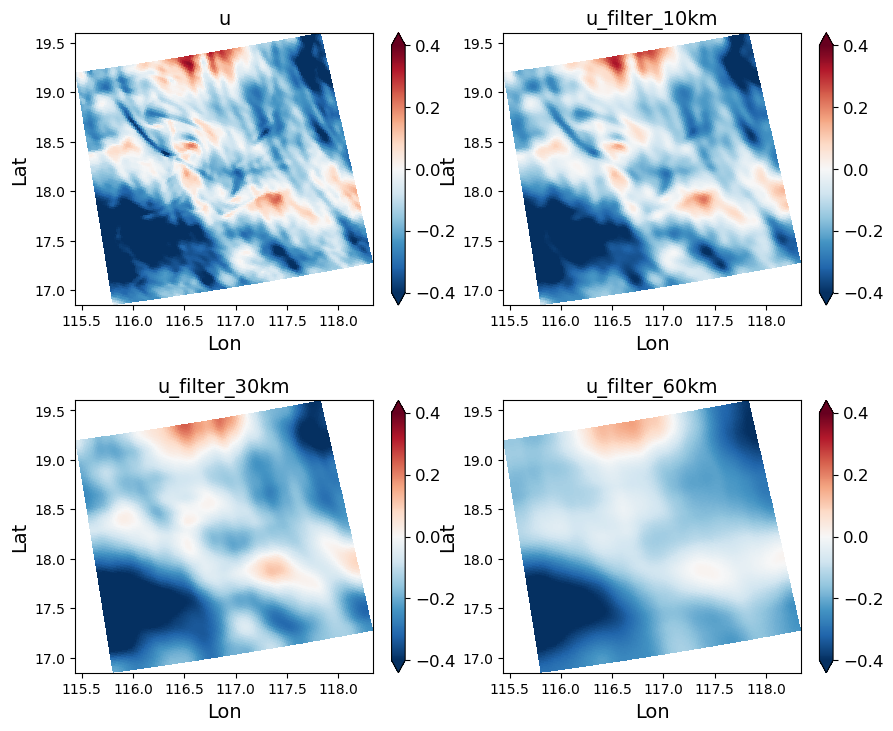

In [31]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

ax = fig.add_subplot(221)
plot = ax.pcolormesh(lon, lat, u, vmin=-0.4, vmax=0.4, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title('u', fontsize=14)

ax = fig.add_subplot(222)
plot = ax.pcolormesh(lon, lat, u_filter_10km, vmin=-0.4, vmax=0.4, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title('u_filter_10km', fontsize=14)

ax = fig.add_subplot(223)
plot = ax.pcolormesh(lon, lat, u_filter_30km, vmin=-0.4, vmax=0.4, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title('u_filter_30km', fontsize=14)

ax = fig.add_subplot(224)
plot = ax.pcolormesh(lon, lat, u_filter_60km, vmin=-0.4, vmax=0.4, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title('u_filter_60km', fontsize=14)

In [23]:
du_dx = xgrid.diff(ds_U_filter.chunk({'xi_rho': -1, 'eta_rho': -1}), 'X')/(1/grid.pm)
dv_dy = xgrid.diff(ds_V_filter.chunk({'xi_rho': -1, 'eta_rho': -1}), 'Y')/(1/grid.pn)
du_dy = xgrid.diff(ds_U_filter.chunk({'xi_rho': -1, 'eta_rho': -1}), 'Y')/(1/grid.pn)
dv_dx = xgrid.diff(ds_V_filter.chunk({'xi_rho': -1, 'eta_rho': -1}), 'X')/(1/grid.pm)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dime

In [27]:
du_dx = xgrid.diff(ds_U_filter.chunk({'xi_rho': -1, 'eta_rho': -1}), 'X')/xgrid.interp((1/grid.pm), 'Y')

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [28]:
du_dx

<xarray.DataArray (time: 8760, eta_rho: 151, xi_u: 150, eta_v: 150, xi_rho: 151)> Size: 36TB
dask.array<truediv, shape=(8760, 151, 150, 150, 151), dtype=float64, chunksize=(8760, 151, 150, 150, 151), chunktype=numpy.ndarray>
Coordinates:
  * eta_rho  (eta_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_u     (xi_u) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
  * xi_rho   (xi_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * eta_v    (eta_v) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149

In [38]:
dudxi, dudeta = xroms.hgrad(ds_U_filter.chunk({'xi_rho': -1, 'eta_rho': -1}), xgrid)
dvdxi, dvdeta = xroms.hgrad(ds_V_filter.chunk({'xi_rho': -1, 'eta_rho': -1}), xgrid)
du_dxi = xroms.to_grid(dudxi, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)
du_deta = xroms.to_grid(dudeta, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)
dv_dxi = xroms.to_grid(dvdxi, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)
dv_deta = xroms.to_grid(dvdeta, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dime

In [49]:
dudxi, dudeta = xroms.hgrad(ds['u'].chunk({'xi_rho': -1, 'eta_rho': -1}), xgrid)
dvdxi, dvdeta = xroms.hgrad(ds['v'].chunk({'xi_rho': -1, 'eta_rho': -1}), xgrid)
du_dxi = xroms.to_grid(dudxi, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)
du_deta = xroms.to_grid(dudeta, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)
dv_dxi = xroms.to_grid(dvdxi, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)
dv_deta = xroms.to_grid(dvdeta, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dime

In [50]:
vrt = dv_dxi - du_deta
vrt

<xarray.DataArray (time: 1440, eta_rho: 151, xi_rho: 151)> Size: 263MB
dask.array<sub, shape=(1440, 151, 151), dtype=float64, chunksize=(1, 151, 151), chunktype=numpy.ndarray>
Coordinates:
  * eta_rho  (eta_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * time     (time) datetime64[ns] 12kB 2017-01-01T00:21:32 ... 2017-03-01T23...
  * xi_rho   (xi_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
Attributes:
    long_name:  horizontal xi derivative of v-momentum component
    name:       dvdxi
    units:      1/m * meter second-1

In [51]:
div = du_dxi + dv_deta
div

<xarray.DataArray (time: 1440, eta_rho: 151, xi_rho: 151)> Size: 263MB
dask.array<add, shape=(1440, 151, 151), dtype=float64, chunksize=(1, 151, 151), chunktype=numpy.ndarray>
Coordinates:
  * eta_rho  (eta_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * time     (time) datetime64[ns] 12kB 2017-01-01T00:21:32 ... 2017-03-01T23...
  * xi_rho   (xi_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
Attributes:
    long_name:  horizontal xi derivative of u-momentum component
    name:       dudxi
    units:      1/m * meter second-1

Text(0.5, 1.0, '$\\delta/f$')

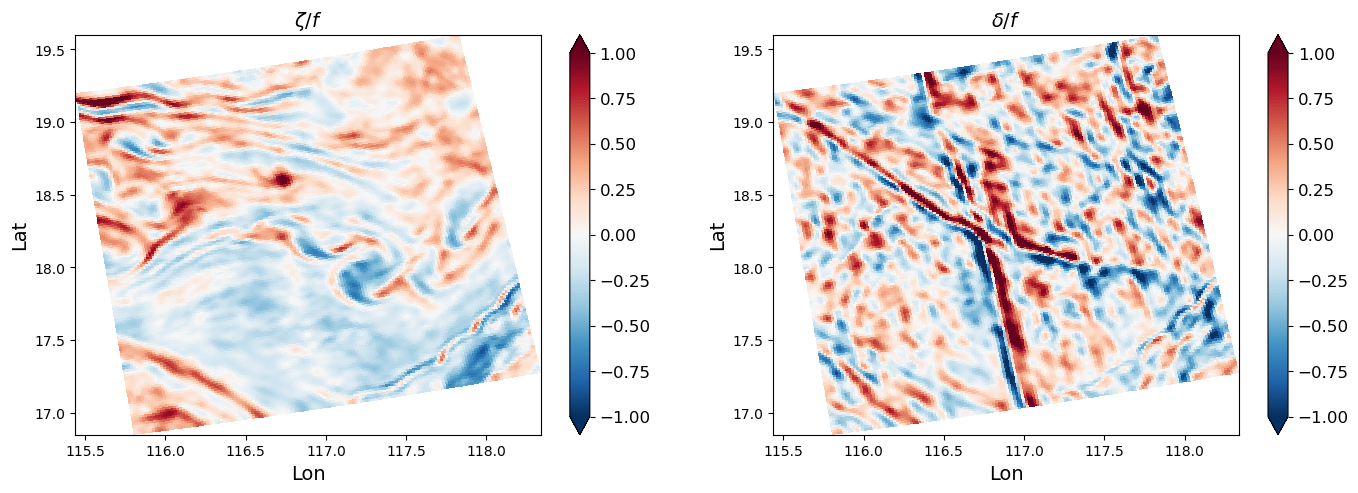

In [52]:
lat=grid['lat_rho'].mean().values
omega = 7.2921*1e-5
f=2*omega*np.sin(np.deg2rad(lat))
lat, lon = np.array(grid['lat_rho']), np.array(grid['lon_rho'])

fig = plt.figure(figsize=(16, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

ax = fig.add_subplot(121)
plot = ax.pcolormesh(lon, lat, vrt[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\zeta/f$', fontsize=14)

ax = fig.add_subplot(122)
plot = ax.pcolormesh(lon, lat, div[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\delta/f$', fontsize=14)

In [56]:
dvdxi = xroms.hgrad(
    ds['v'],
    xgrid,
    which="xi",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)
dudeta = xroms.hgrad(
    ds['u'],
    xgrid,
    which="eta",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)

vrt = dvdxi - dudeta

dudxi = xroms.hgrad(
    ds['u'],
    xgrid,
    which="xi",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)
dvdeta = xroms.hgrad(
    ds['v'],
    xgrid,
    which="eta",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)

div = dudxi + dvdeta

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dime

In [58]:
vrt

<xarray.DataArray (time: 1440, eta_rho: 151, xi_u: 150, eta_v: 150, xi_rho: 151)> Size: 6TB
dask.array<sub, shape=(1440, 151, 150, 150, 151), dtype=float64, chunksize=(1, 151, 150, 150, 151), chunktype=numpy.ndarray>
Coordinates:
  * eta_rho  (eta_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * time     (time) datetime64[ns] 12kB 2017-01-01T00:21:32 ... 2017-03-01T23...
  * xi_u     (xi_u) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
  * xi_rho   (xi_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * eta_v    (eta_v) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Attributes:
    long_name:  horizontal xi derivative of v-momentum component
    name:       dvdxi
    units:      1/m * meter second-1

TypeError: Dimensions of C (151, 150, 150, 151) should be one smaller than X(151) and Y(151) while using shading='flat' see help(pcolormesh)

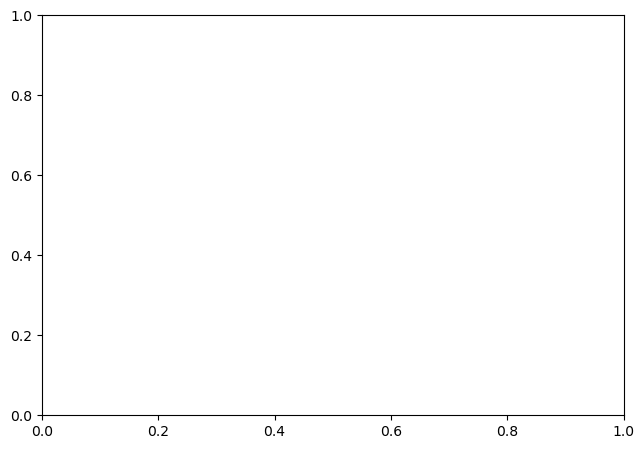

In [57]:
lat=grid['lat_rho'].mean().values
omega = 7.2921*1e-5
f=2*omega*np.sin(np.deg2rad(lat))
lat, lon = np.array(grid['lat_rho']), np.array(grid['lon_rho'])

fig = plt.figure(figsize=(16, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

ax = fig.add_subplot(121)
plot = ax.pcolormesh(lon, lat, vrt[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\zeta/f$', fontsize=14)

ax = fig.add_subplot(122)
plot = ax.pcolormesh(lon, lat, div[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\delta/f$', fontsize=14)

### xscale temporal filter

In [32]:
Time_length = 24*30 # grid_num*2 km filter
time_length = 8760
eta_length, xi_length = 151, 151

wt_U = ds['u'].window
wt_U.set(n={'time':Time_length}, window={'time':'hann'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_U_filter = wt_U.convolve()

wt_V = ds['v'].window
wt_V.set(n={'time':Time_length}, window={'time':'hann'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_V_filter = wt_V.convolve()

wt_U2 = (ds['u']**2).window
wt_U2.set(n={'time':Time_length}, window={'time':'hann'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_U2_filter = wt_U2.convolve()

wt_V2 = (ds['v']**2).window
wt_V2.set(n={'time':Time_length}, window={'time':'hann'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_V2_filter = wt_V2.convolve()

wt_UV = (ds['u']*ds['v']).window
wt_UV.set(n={'time':Time_length}, window={'time':'hann'},chunks={"time": time_length,'eta_rho':1,'xi_rho':xi_length})
ds_UV_filter = wt_UV.convolve()

### compute PI

In [33]:
PI_1 = (ds_U2_filter-ds_U_filter**2)*du_dxi  # [f(u^2) - f(u)^2]*f(du/dx)
PI_2 = (ds_V2_filter-ds_V_filter**2)*dv_deta  # [f(v^2) - f(v)^2]*f(dv/dy)
PI_3 = (ds_UV_filter - ds_U_filter*ds_V_filter)*(du_deta+dv_dxi) # [f(uv) - f(u)f(v)]*[f(du/dy) + f(dv/dx)]

PI_cg_single = -(PI_1+PI_2+PI_3)


In [34]:
chunks = {"time": time_length,'eta_rho':1,'xi_rho':xi_length}

# save
PI_cg_single = PI_cg_single.chunk(chunks)
PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
PI_cg_single = PI_cg_single.to_dataset()

print('\n data size: %.1f GB' %(PI_cg_single.nbytes / 1e9))


 data size: 1.6 GB


In [35]:
%%time
PI_cg_single.to_zarr(sub_savepath + 'surface_PI_cg_30days_test.zarr', mode='w') 

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 13.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 33.2 s, sys: 12 s, total: 45.3 s
Wall time: 1min 35s


In [42]:
%%time
ds = xr.open_zarr(sub_savepath + 'surface_PI_cg_60km_test.zarr')
PI_plot = ds.PI_cg_single.mean(dim={'time'}).load()

CPU times: user 333 ms, sys: 120 ms, total: 453 ms
Wall time: 643 ms


In [43]:
ds = ds.assign_coords(time=ds_u['time'])

In [22]:
ds_winter = ds.sel(time=slice("2016-12-01", "2017-3-01") )
PI_plot = ds_winter.PI_cg_single.mean(dim={'time'}).load()

In [38]:
PI_plot

<xarray.DataArray 'PI_cg_single' (eta_rho: 151, xi_rho: 151)> Size: 182kB
array([[ 1.39818282e-09,  1.40621993e-09,  1.41836494e-09, ...,
        -2.13898934e-09,  2.13909001e-10,  1.36767588e-09],
       [ 1.77932281e-09,  1.79742121e-09,  1.83988751e-09, ...,
        -1.27739742e-09,  1.07583706e-09,  2.22444718e-09],
       [ 2.47647646e-09,  2.50742975e-09,  2.57003059e-09, ...,
         5.07105128e-10,  2.87806020e-09,  4.00115445e-09],
       ...,
       [ 1.70322361e-09,  2.53320665e-09,  4.09604547e-09, ...,
         8.50814755e-10, -1.02647764e-08, -1.59998590e-08],
       [ 2.08785142e-09,  2.89448500e-09,  4.45178813e-09, ...,
         1.09269017e-08, -4.97261082e-11, -5.62507215e-09],
       [ 2.25386007e-09,  3.05000335e-09,  4.61503830e-09, ...,
         1.60790086e-08,  5.14865475e-09, -3.28596149e-10]])
Coordinates:
  * eta_rho  (eta_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xi_rho   (xi_rho) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

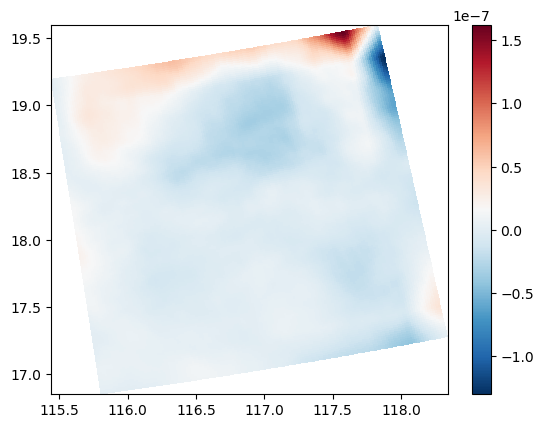

In [39]:
lat, lon = np.array(grid['lat_rho']), np.array(grid['lon_rho'])

plt.pcolormesh(lon, lat, PI_plot, cmap='RdBu_r')
plt.colorbar()

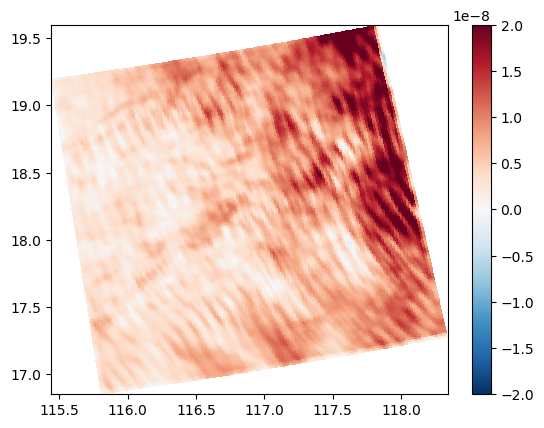

In [67]:
lat, lon = np.array(grid['lat_rho']), np.array(grid['lon_rho'])

vmin, vmax = -2*1e-8, 2*1e-8
plt.pcolormesh(lon, lat, PI_plot, vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.colorbar()

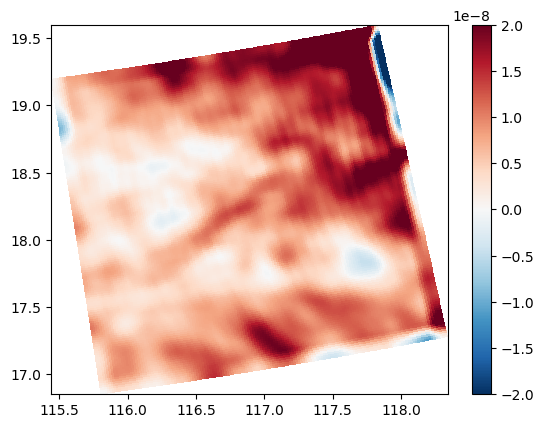

In [86]:
lat, lon = np.array(grid['lat_rho']), np.array(grid['lon_rho'])

vmin, vmax = -2*1e-8, 2*1e-8
plt.pcolormesh(lon, lat, PI_plot, vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.colorbar()

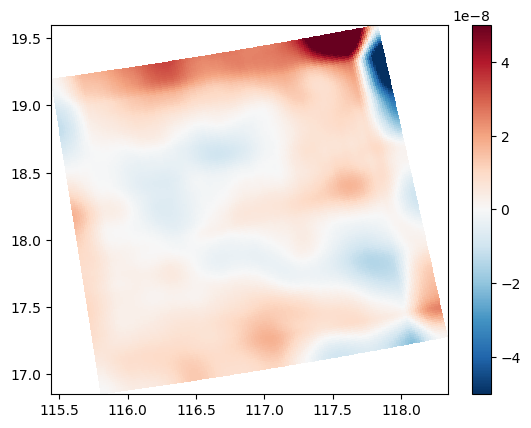

In [18]:
lat, lon = np.array(grid['lat_rho']), np.array(grid['lon_rho'])

vmin, vmax = -0.5*1e-7, 0.5*1e-7
plt.pcolormesh(lon, lat, PI_plot, vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.colorbar()

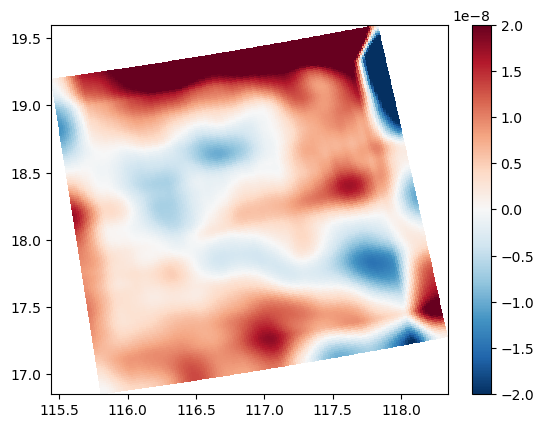

In [44]:
lat, lon = np.array(grid['lat_rho']), np.array(grid['lon_rho'])

vmin, vmax = -2*1e-8, 2*1e-8
plt.pcolormesh(lon, lat, PI_plot, vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.colorbar()

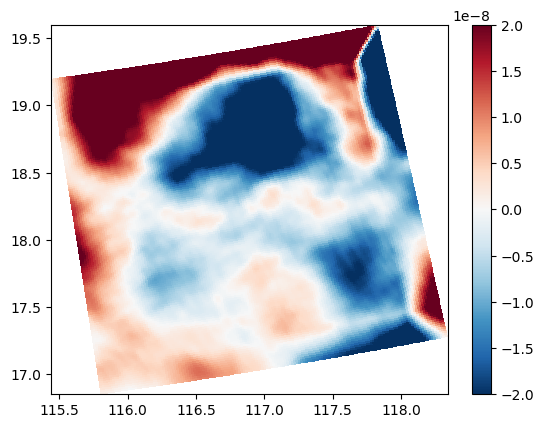

In [41]:
lat, lon = np.array(grid['lat_rho']), np.array(grid['lon_rho'])

vmin, vmax = -2*1e-8, 2*1e-8
plt.pcolormesh(lon, lat, PI_plot, vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.colorbar()

### butterworth filter (temporal)

In [7]:
dudxi, dudeta = xroms.hgrad(ds.u, xgrid)
dvdxi, dvdeta = xroms.hgrad(ds.v, xgrid)
du_dxi = xroms.to_grid(dudxi, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)
du_deta = xroms.to_grid(dudeta, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)
dv_dxi = xroms.to_grid(dvdxi, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)
dv_deta = xroms.to_grid(dvdeta, xgrid,
              hcoord="rho",
              hboundary="extend", hfill_value=None)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dime

In [8]:
ds_u = ds_u.chunk({"time": 8760,'eta_rho':16,'xi_rho':1502})
ds_v = ds_v.chunk({"time": 8760,'eta_rho':16,'xi_rho':1502})
ds_u

<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    u        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(8760, 16, 1502), meta=np.ndarray>

In [ ]:
%%time
ds_u.to_zarr(sub_savepath+'surface_u_re-rechunk.zarr',mode='w')

In [19]:
%%time
ds_u = ds_u.chunk({"time": 8760,'eta_rho':16,'xi_rho':1502})
ds_v = ds_v.chunk({"time": 8760,'eta_rho':16,'xi_rho':1502})


ds_u.to_zarr(sub_savepath+'surface_u_re-rechunk.zarr',mode='w',safe_chunks=False)
ds_v.to_zarr(sub_savepath+'surface_v_re-rechunk.zarr',mode='w',safe_chunks=False)

2025-06-20 07:41:31,073 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.27 GiB -- Worker memory limit: 15.69 GiB
2025-06-20 07:41:40,109 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.29 GiB -- Worker memory limit: 15.69 GiB


CPU times: user 1min 37s, sys: 37.3 s, total: 2min 14s
Wall time: 21min 28s


In [9]:
def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

In [10]:
cut_1 = 1/24/3600 # 1 day
cut_5 = 1/120/3600   # 5 days

fs = 1/3600
nyq = 0.5*fs
cut_1d = cut_1/nyq
cut_5d = cut_5/nyq

b, a = butter(4, cut_1d , 'low')
c, d = butter(4, cut_5d, 'low')

In [28]:
ds_u = xr.open_zarr(sub_savepath + 'surface_u_re-rechunk.zarr')
ds_v = xr.open_zarr(sub_savepath + 'surface_v_re-rechunk.zarr')

In [ ]:
ds_u = ds_u.chunk({"time": 1465,'eta_rho':1,'xi_rho':15})
ds_v = ds_v.chunk({"time": 1465,'eta_rho':1,'xi_rho':15})


In [29]:
ds_u

<xarray.Dataset> Size: 68GB
Dimensions:  (eta_rho: 1296, time: 8760, xi_rho: 1502)
Coordinates:
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
Data variables:
    u        (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [11]:
u_test = ds_u.isel(eta_rho=7,xi_rho=7)
u_test

<xarray.Dataset> Size: 105kB
Dimensions:  (time: 8760)
Coordinates:
    eta_rho  int64 8B 7
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
    xi_rho   int64 8B 7
Data variables:
    u        (time) float32 35kB dask.array<chunksize=(8760,), meta=np.ndarray>

In [12]:
u_test = ds_u.isel(eta_rho=977,xi_rho=811)
u_test

<xarray.Dataset> Size: 105kB
Dimensions:  (time: 8760)
Coordinates:
    eta_rho  int64 8B 977
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
    xi_rho   int64 8B 811
Data variables:
    u        (time) float32 35kB dask.array<chunksize=(8760,), meta=np.ndarray>

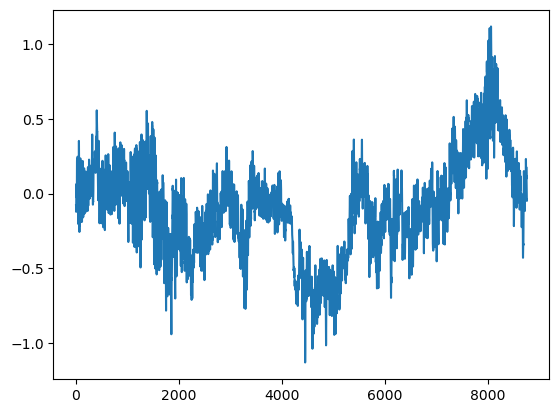

In [13]:
plt.plot(u_test.u)

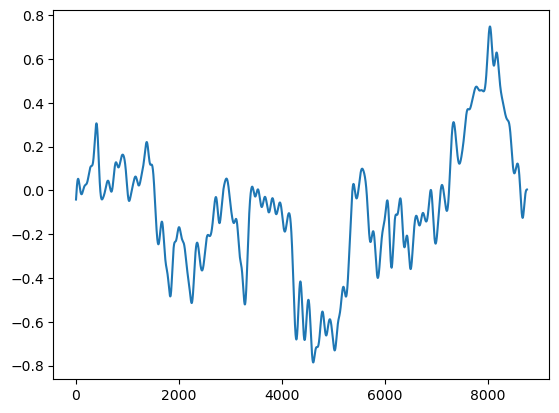

In [14]:
plt.plot(butter_filter(u_test.u, c, d))

In [37]:
%%time
PI_1 = ( butter_filter(ds_u.u**2, c, d) - butter_filter(ds_u.u, c, d)**2 ) * du_dxi
PI_2 = ( butter_filter(ds_v.v**2, c, d) - butter_filter(ds_v.v, c, d)**2 ) * dv_deta
PI_3 = ( butter_filter(ds_v.v*ds_u.u, c, d) - butter_filter(ds_v.v, c, d)*butter_filter(ds_u.u, c, d) ) * (du_deta + dv_dxi)

PI_cg_5d = -(PI_1+PI_2+PI_3)
PI_cg_5d

CPU times: user 51.8 ms, sys: 3.07 ms, total: 54.8 ms
Wall time: 57.1 ms


<xarray.DataArray (time: 1465, eta_rho: 0, xi_rho: 0)> Size: 0B
dask.array<neg, shape=(1465, 0, 0), dtype=float64, chunksize=(1, 0, 0), chunktype=numpy.ndarray>
Coordinates:
  * eta_rho  (eta_rho) int64 0B 
  * time     (time) datetime64[ns] 12kB 2016-07-31T23:21:32 ... 2016-09-30T23...
  * xi_rho   (xi_rho) int64 0B 
Attributes:
    long_name:  u-momentum component
    name:       u
    units:      meter second-1

In [23]:
PI_1 = ( butter_filter(ds_u.u**2, b, a) - butter_filter(ds_u.u, b, a)**2 ) * du_dxi

In [ ]:
%%time
PI_1 = ( butter_filter(ds_u.u**2, b, a) - butter_filter(ds_u.u, b, a)**2 ) * du_dxi
PI_2 = ( butter_filter(ds_v.v**2, b, a) - butter_filter(ds_v.v, b, a)**2 ) * dv_deta
PI_3 = ( butter_filter(ds_v.v*ds_u.u, b, a) - butter_filter(ds_v.v, b, a)*butter_filter(ds_u.u, b, a) ) * (du_deta + dv_dxi)

PI_cg_1d = -(PI_1+PI_2+PI_3)
PI_cg_1d.load()

In [ ]:
%%time
PI_cg_1d.to_zarr(sub_savepath+'surface_PI_cg_1d.zarr',mode='w')

In [18]:
PI_cg_1d = xr.open_zarr(sub_savepath + 'surface_PI_cg_1d_try.zarr')
PI_cg_1d

<xarray.Dataset> Size: 12kB
Dimensions:                        (time: 1465, eta_rho: 0, xi_rho: 0)
Coordinates:
  * eta_rho                        (eta_rho) int64 0B 
  * time                           (time) datetime64[ns] 12kB 2016-07-31T23:2...
  * xi_rho                         (xi_rho) int64 0B 
Data variables:
    __xarray_dataarray_variable__  (time, eta_rho, xi_rho) float64 0B dask.array<chunksize=(1465, 0, 0), meta=np.ndarray>